# DGA Detection
## Experiment 3: Building a DGA Classifier
<b><p id="intro" style="color: green">In this notebook we use the full dataset "dga_data_full.csv", apply the function for N-gram feature extraction and extract TLD feature from domain string.</p></b>
<a href="#WorkingOn">Go back</a>

In [1]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>

In [2]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_full.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [3]:
print(df.shape)
missing_values = df.isnull().sum()
print(missing_values)

(160000, 4)
isDGA       0
domain      2
host        0
subclass    0
dtype: int64


In [4]:
# Drop the rows with missing values
df = df.dropna()
print(df.shape)

(159998, 4)


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(duplicates)

0


In [7]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 80000
Legit: 79998


<b><h3>Part 2 - Feature Engineering</h3></b>

In [8]:
df.drop(['domain', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(159998, 2)


,isDGA,host
0,dga,6xzxsw3sokvg1tc752y1a6p0af.com
1,dga,glbtlxwwhbnpxs.ru
2,dga,xxmamopyipbfpk.ru
3,dga,zfd5szpi18i85wj9uy13l69rg.net
4,dga,jpqftymiuver.ru


In [9]:
# Change column name 'host' to 'root_domain_name'
df.rename(columns={'host':'domain_name'}, inplace=True)

In [10]:
# Transform IsDGA to binary values
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain_name
0,1,6xzxsw3sokvg1tc752y1a6p0af.com
1,1,glbtlxwwhbnpxs.ru
2,1,xxmamopyipbfpk.ru
3,1,zfd5szpi18i85wj9uy13l69rg.net
4,1,jpqftymiuver.ru


In [11]:
# Get 'domain_name' length and add as column 'domain_name_length'
df['domain_name_length'] = df['domain_name'].apply(lambda x: len(x))
df.head()

,isDGA,domain_name,domain_name_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30
1,1,glbtlxwwhbnpxs.ru,17
2,1,xxmamopyipbfpk.ru,17
3,1,zfd5szpi18i85wj9uy13l69rg.net,29
4,1,jpqftymiuver.ru,15


In [12]:
# Function to get the top level domain from 'host' and its length and add both as 2 new columns 'tld' and 'tld_length' 
def get_tld_length(domain):
    tld = domain.split('.')[-1]
    tld_length = len(tld)
    return tld, tld_length

df['tld'], df['tld_length'] = zip(*df['domain_name'].map(get_tld_length))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3
1,1,glbtlxwwhbnpxs.ru,17,ru,2
2,1,xxmamopyipbfpk.ru,17,ru,2
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3
4,1,jpqftymiuver.ru,15,ru,2


In [13]:
# Function to check if there is a second-level domain
def has_second_level_domain(domain):
    if len(domain.split('.')) > 2:
        return 'Yes'
    else:
        return 'No'

# Function to count the length of the second-level domain
def second_level_domain_length(domain):
    if has_second_level_domain(domain) == 'Yes':
        return len(domain.split('.')[1])
    else:
        return 0

In [14]:
# Apply the functions to the 'host' column and add the results as 2 new columns 'has_2ld' and '2ld_length'
df['has_2ld'] = df['domain_name'].apply(has_second_level_domain)
df['2ld_length'] = df['domain_name'].apply(second_level_domain_length)
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0
4,1,jpqftymiuver.ru,15,ru,2,No,0


In [15]:
# check if we have special characters in 'domain_name' column such as '-', '_'
def has_special_characters(domain):
    if re.search(r'[-_]', domain):
        return 'Yes'
    else:
        return 'No'
    
df['has_special_char'] = df['domain_name'].apply(has_special_characters)
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No
4,1,jpqftymiuver.ru,15,ru,2,No,0,No


In [16]:
# count and print unique values in has_special_characters column
print(df['has_special_char'].value_counts())
# show sample (10) of rows with special characters
df[df['has_special_char'] == 'Yes'].sample(10)

has_special_char
No     153469
Yes      6529
Name: count, dtype: int64


,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char
125937,0,bonus-hits.com,14,com,3,No,0,Yes
108249,0,nissan-global.com,17,com,3,No,0,Yes
124097,0,webmaster-hub.com,17,com,3,No,0,Yes
111104,0,vid-converter.com,17,com,3,No,0,Yes
149119,0,ricettario-bimby.it,19,it,2,No,0,Yes
80936,0,schwarzwaelder-bote.de,22,de,2,No,0,Yes
94220,0,thunderbird-mail.de,19,de,2,No,0,Yes
103945,0,credit-par-internet.com,23,com,3,No,0,Yes
107165,0,3e-online.com,13,com,3,No,0,Yes
94862,0,ranobe-mori.net,15,net,3,No,0,Yes


In [19]:
def count_special_characters(domain):
    special_chars = re.findall(r'[^a-zA-Z0-9\.]', domain) # except for letters, numbers and '.'
    return len(special_chars)

df['special_char_count'] = df['domain_name'].apply(count_special_characters)
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0


In [21]:
df[df['has_special_char'] == 'Yes'].sample(5)

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count
139391,0,clash-media.com,15,com,3,No,0,Yes,1
82418,0,ntt-east.net,12,net,3,No,0,Yes,1
97655,0,fond-ecran-image.com,20,com,3,No,0,Yes,2
103291,0,derev-grad.ru,13,ru,2,No,0,Yes,1
144228,0,foro-escorts.com.ar,19,ar,2,Yes,3,Yes,1


In [22]:
# Function to calculate number of digits 
def numDigits(domain):
    return sum(c.isdigit() for c in domain)

# Function to get the index of the first digit in a string
def firstDigitIndex(domain):
    for i, c in enumerate(domain):
        if c.isdigit():
            return i + 1
    return 0

In [23]:
df['digits'] = df['domain_name'].apply(lambda x: numDigits(x))
df['first_digit_idx'] = df['domain_name'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,first_digit_idx
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,1
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,4
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,0


In [24]:
# Function to calculate ratio of consonant characters in domain name
def consonant_ratio(domain):
    consonants = sum(1 for char in domain if char.isalpha() and char.lower() not in 'aeiou')
    return consonants / len(domain)

# Function to calculate ratio of vowels in domain name
def vowel_ratio(domain):
    vowels = sum(1 for char in domain if char.lower() in 'aeiou')
    return vowels / len(domain)

# Function to calculate ratio of numeric characters in domain name
def numeric_ratio(domain):
    numerics = sum(1 for char in domain if char.isdigit())
    return numerics / len(domain)

# Function to calculate ratio of special characters (excluding dot ".") in domain name
def special_char_ratio(domain):
    special_chars = sum(1 for char in domain if char in r'!@#$%^&*()-_=+[{]}\|;:\'",<>/?`~')
    return special_chars / len(domain)

# Function to calculate percentage of consonant characters in domain name
def consonant_percentage(domain):
    consonants = sum(1 for char in domain if char.isalpha() and char.lower() not in 'aeiou')
    return (consonants / len(domain)) * 100

# Function to calculate percentage of vowels in domain name
def vowel_percentage(domain):
    vowels = sum(1 for char in domain if char.lower() in 'aeiou')
    return (vowels / len(domain)) * 100

# Function to calculate percentage of numeric characters in domain name
def numeric_percentage(domain):
    numerics = sum(1 for char in domain if char.isdigit())
    return (numerics / len(domain)) * 100

# Function to calculate percentage of special characters (excluding dot ".") in domain name
def special_char_percentage(domain):
    special_chars = sum(1 for char in domain if char in r'!@#$%^&*()-_=+[{]}\|;:\'",<>/?`~')
    return (special_chars / len(domain)) * 100

In [25]:
df['cons_ratio'] = df['domain_name'].apply(consonant_ratio)
df['vowel_ratio'] = df['domain_name'].apply(vowel_ratio)
df['num_ratio'] = df['domain_name'].apply(numeric_ratio)
df['specialchar_ratio'] = df['domain_name'].apply(special_char_ratio)
df['cons_percent'] = df['domain_name'].apply(consonant_percentage)
df['vowel_percent'] = df['domain_name'].apply(vowel_percentage)
df['num_percent'] = df['domain_name'].apply(numeric_percentage)
df['specialchar_percent'] = df['domain_name'].apply(special_char_percentage)
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,first_digit_idx,cons_ratio,vowel_ratio,num_ratio,specialchar_ratio,cons_percent,vowel_percent,num_percent,specialchar_percent
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,1,0.533333,0.133333,0.300000,0.0,53.333333,13.333333,30.000000,0.0
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,0,0.882353,0.058824,0.000000,0.0,88.235294,5.882353,0.000000,0.0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,0,0.705882,0.235294,0.000000,0.0,70.588235,23.529412,0.000000,0.0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,4,0.482759,0.137931,0.344828,0.0,48.275862,13.793103,34.482759,0.0
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,0,0.666667,0.266667,0.000000,0.0,66.666667,26.666667,0.000000,0.0


In [26]:
# Function to get the length of the longest consonant string
def longest_consonant_string(domain):
    consonants = 'bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in consonants:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length

# Function to get the length of the longest vowel sequence
def longest_vowel_string(domain):
    vowels = 'aeiouAEIOU'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in vowels:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length

# Function to get the length of the longest character string
def longest_character_string(domain):
    return max(len(s) for s in domain.split('.'))

# Function to get the length of the longest string of numbers
def longest_number_string(domain):
    numbers = '0123456789'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in numbers:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length

In [27]:
# Apply the functions to the 'host' column and add the results as 4 new columns 'longest_cons_str', 'longest_vowel_str', 'longest_char_str' and 'longest_num_str'
df['longest_cons_str'] = df['domain_name'].apply(longest_consonant_string)
df['longest_vowel_str'] = df['domain_name'].apply(longest_vowel_string)
df['longest_char_str'] = df['domain_name'].apply(longest_character_string)
df['longest_num_str'] = df['domain_name'].apply(longest_number_string)
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,...,num_ratio,specialchar_ratio,cons_percent,vowel_percent,num_percent,specialchar_percent,longest_cons_str,longest_vowel_str,longest_char_str,longest_num_str
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,...,0.300000,0.0,53.333333,13.333333,30.000000,0.0,5,1,26,3
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,...,0.000000,0.0,88.235294,5.882353,0.000000,0.0,14,1,14,0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,...,0.000000,0.0,70.588235,23.529412,0.000000,0.0,5,1,14,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,...,0.344828,0.0,48.275862,13.793103,34.482759,0.0,3,1,25,2
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,...,0.000000,0.0,66.666667,26.666667,0.000000,0.0,7,2,12,0


In [29]:
# Function to calculate the average length of consonant strings
def average_consonant_length(domain):
    consonants = 'bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ'
    consonant_lengths = [len(s) for s in domain.split('.') if all(c in consonants for c in s)]
    return sum(consonant_lengths) / len(consonant_lengths) if consonant_lengths else 0

# Function to calculate the average length of vowel strings
def average_vowel_length(domain):
    vowels = 'aeiouAEIOU'
    vowel_lengths = [len(s) for s in domain.split('.') if all(c in vowels for c in s)]
    return sum(vowel_lengths) / len(vowel_lengths) if vowel_lengths else 0

# Function to calculate the average length of character strings
def average_character_length(domain):
    return sum(len(s) for s in domain.split('.')) / len(domain.split('.'))

# Function to calculate the average length of alphanumeric strings
def average_alphanumeric_length(domain):
    alphanumeric_lengths = [len(s) for s in domain.split('.') if s.isalnum()]
    return sum(alphanumeric_lengths) / len(alphanumeric_lengths) if alphanumeric_lengths else 0

In [30]:

df['avg_cons_length'] = df['domain_name'].apply(lambda x: average_consonant_length(x))
df['avg_vowel_length'] = df['domain_name'].apply(lambda x: average_vowel_length(x))
df['avg_char_length'] = df['domain_name'].apply(lambda x: average_character_length(x))
df['avg_alphnum_length'] = df['domain_name'].apply(lambda x: average_alphanumeric_length(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,...,num_percent,specialchar_percent,longest_cons_str,longest_vowel_str,longest_char_str,longest_num_str,avg_cons_length,avg_vowel_length,avg_char_length,avg_alphnum_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,...,30.000000,0.0,5,1,26,3,0.0,0.0,14.5,14.5
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,...,0.000000,0.0,14,1,14,0,14.0,0.0,8.0,8.0
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,...,0.000000,0.0,5,1,14,0,0.0,0.0,8.0,8.0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,...,34.482759,0.0,3,1,25,2,0.0,0.0,14.0,14.0
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,...,0.000000,0.0,7,2,12,0,0.0,0.0,7.0,7.0


In [31]:
# We want now to check average_character_length and average_alphanumeric_length are the same 
df['avg_char_length'].equals(df['avg_alphnum_length'])
# How can we check if they are the same? 
# We can use the function equals() to check if the two columns are the same. If the function returns True, the two columns are the same.

False

In [32]:
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
top_english_words.head()
d = top_english_words
# Save as pickle file
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

In [33]:
# Function to calculate Shannon Entropy
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [34]:
df['entropy'] = df['domain_name'].apply(lambda x: H_entropy(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,...,specialchar_percent,longest_cons_str,longest_vowel_str,longest_char_str,longest_num_str,avg_cons_length,avg_vowel_length,avg_char_length,avg_alphnum_length,entropy
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,...,0.0,5,1,26,3,0.0,0.0,14.5,14.5,4.440224
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,...,0.0,14,1,14,0,14.0,0.0,8.0,8.0,3.616875
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,...,0.0,5,1,14,0,0.0,0.0,8.0,8.0,3.572469
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,...,0.0,3,1,25,2,0.0,0.0,14.0,14.0,4.444188
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,...,0.0,7,2,12,0,0.0,0.0,7.0,7.0,3.640224


In [35]:
with open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'rb') as f:
    d = load(f)

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
def ngrams(word, n):    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if ngram in d:
            count_sum+=d[ngram]
    
    try:
        feature = count_sum/(len(domain)-n+1)

    except:
        feature = 0
    
    return feature
    
def average_ngram_feature(l_ngram_feature):   
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [36]:
dict_freq = { word[0]: num for num, word in enumerate(d.values, 1) }

In [37]:
df['ngrams'] = df['domain_name'].apply(lambda x: average_ngram_feature([ngram_feature(x, dict_freq, n) for n in [1,2,3]]))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,has_2ld,2ld_length,has_special_char,special_char_count,digits,...,longest_cons_str,longest_vowel_str,longest_char_str,longest_num_str,avg_cons_length,avg_vowel_length,avg_char_length,avg_alphnum_length,entropy,ngrams
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,No,0,No,0,9,...,5,1,26,3,0.0,0.0,14.5,14.5,4.440224,453.223536
1,1,glbtlxwwhbnpxs.ru,17,ru,2,No,0,No,0,0,...,14,1,14,0,14.0,0.0,8.0,8.0,3.616875,1136.419118
2,1,xxmamopyipbfpk.ru,17,ru,2,No,0,No,0,0,...,5,1,14,0,0.0,0.0,8.0,8.0,3.572469,1032.404412
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,No,0,No,0,10,...,3,1,25,2,0.0,0.0,14.0,14.0,4.444188,378.545947
4,1,jpqftymiuver.ru,15,ru,2,No,0,No,0,0,...,7,2,12,0,0.0,0.0,7.0,7.0,3.640224,1402.937851


In [38]:
# Save the df as a new csv file named 'dga_features.csv'
df.to_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/processed/dga_features_pr4.csv', index=False)

In [203]:
df_final = df
print(df_final.shape)
print(df_final['isDGA'].value_counts())

(159998, 29)
isDGA
1    80000
0    79998
Name: count, dtype: int64


In [59]:
# Now drop the columns 'host' and 'tld'
df_final.drop(['host', 'tld'], axis=1, inplace=True)
df_final.head()

,isDGA,length,digits,entropy,vowel_cons,firstDigitIndex,ngrams
0,1,30,9,4.440224,0.250000,1,453.223536
1,1,17,0,3.616875,0.066667,0,1136.419118
2,1,17,0,3.572469,0.333333,0,1032.404412
3,1,29,10,4.444188,0.285714,4,378.545947
4,1,15,0,3.640224,0.400000,0,1402.937851


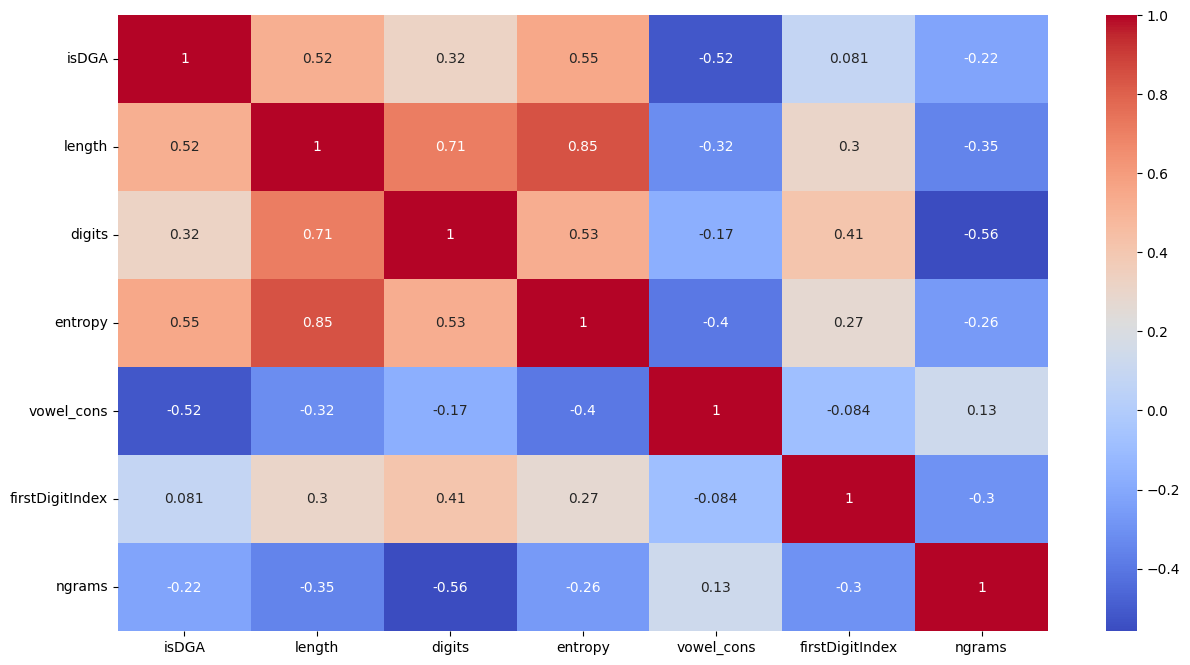

In [61]:
# Now let's visualize the features to see which will be of value and which will not be of value
plt.figure(figsize=(15, 8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm')
plt.show()

<b><h3>Part 3 - Training the Decision Tree Classifier model</h3></b>

In [62]:
# Split the data into features and target
# We are going to only use the most relevant features
X = df_final[['length', 'digits', 'entropy', 'vowel_cons', 'firstDigitIndex', 'ngrams']]
y = df_final['isDGA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
y_pred = dt_clf.predict(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 82.15%


In [97]:
# optimize the hyperparameters of the Decision Tree Classifier
dt_clf_opt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=42)
dt_clf_opt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [98]:
y_pred = dt_clf_opt.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.95%


In [100]:
# Save the model
dump(dt_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_dt_clf_opt.pkl', 'wb'))

<b><h3>Part 4 - Training other classifiers</h3></b>
<h4 style="color: red">Random Forest Classifier</h4>

In [101]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred = rf_clf.predict(X_test)

In [103]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 83.59%


In [104]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

grid_rf = GridSearchCV(rf_clf, hyperparameters, cv=10) 
grid_rf

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [124]:
rf_clf_opt = RandomForestClassifier(n_estimators=100, 
                                    criterion='gini', 
                                    max_depth=15, 
                                    min_samples_leaf=5, 
                                    min_samples_split=20, 
                                    random_state=42)
rf_clf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [125]:
y_pred = rf_clf_opt.predict(X_test)

In [126]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 86.86%


In [127]:
# Save the model
dump(rf_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_rf_clf_opt.pkl', 'wb'))

<h4 style="color: red">K-NN Classifier</h4>

In [128]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [129]:
y_pred = knn_clf.predict(X_test)

In [130]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 77.74%


In [146]:
knn_clf_opt = KNeighborsClassifier(n_neighbors=7, 
                                   weights='distance', 
                                   leaf_size=10, 
                                   p=1, 
                                   algorithm='kd_tree')
knn_clf_opt.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=7, p=1,
                     weights='distance')

In [147]:
y_pred = knn_clf_opt.predict(X_test)

In [148]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 79.40%


In [149]:
# Save the model
dump(knn_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_knn_clf_opt.pkl', 'wb'))

<h4 style="color: red">Boosting Algorithms</h4>

In [150]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [151]:
y_pred = xgb_clf.predict(X_test)

In [152]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 87.03%


In [156]:
xgb_clf_opt = XGBClassifier(n_estimators=200, 
                            max_depth=7, 
                            learning_rate=0.1, 
                            subsample=0.7, 
                            colsample_bytree=0.7, 
                            gamma=50, 
                            random_state=42)

xgb_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [157]:
y_pred = xgb_clf_opt.predict(X_test)

In [158]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.91%


In [159]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [160]:
y_pred = gb_clf.predict(X_test)

In [161]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.83%


In [162]:
# optimize the hyperparameters of the Gradient Boosting Classifier using a Randomized Search
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'learning_rate': [0.01, 0.1, 0.5, 1], 
                     'subsample': [0.5, 0.7, 1.0], 
                     'max_depth': [3, 5, 7, 9], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5], 
                     'max_features': ['auto', 'sqrt', 'log2']}

random_gb = RandomizedSearchCV(gb_clf, hyperparameters, cv=10, n_iter=100, random_state=42)
random_gb

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1],
                                        'max_depth': [3, 5, 7, 9],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42)

In [163]:
# Fit the model
random_gb.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters found: {random_gb.best_params_}")

KeyboardInterrupt: 

<a id="WorkingOn" href="#intro">Go up</a>